# Narrowing down EDA
We want to combine individual EDA into what supports our problem statement and will support our upcoming modelling

### Key factors that the EDA should answer 
- How common are delays 
- Patterns or cerrelations in delay frequency or severity 
- Provide hypothesis for modelling (which features are most relevant)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data_with_clusters.csv')
df.head()

,YEAR,QUARTER,MONTH,DAY,DAY_OF_WEEK,MKT_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,lagged_delay_flag,prev_real_delay,FL_DATE,origin_flights_day,origin_bucket,dest_flights_day,destination_bucket,distance_bucket,airline_bucket,HOUR,cluster
0,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",700,707.0,7.0,0.0,0.0,950.0,15.0,1.0,1.0,0.0,NaN,95.0,103.0,619.0,7.0,0.0,8.0,0.0,0.0,0,0.0,2024-01-01,67,1,241,2,2,1,7,0
1,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",1830,1826.0,0.0,0.0,-1.0,2112.0,2.0,0.0,0.0,0.0,NaN,100.0,106.0,619.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2024-01-01,67,1,241,2,2,1,18,0
2,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10800,1080003,"Burbank, CA",1420,1426.0,6.0,0.0,0.0,1516.0,0.0,0.0,-1.0,0.0,NaN,130.0,110.0,672.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2024-01-01,67,1,90,1,3,1,14,1
3,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10821,1082106,"Baltimore, MD",1500,1514.0,14.0,0.0,0.0,2050.0,15.0,1.0,1.0,0.0,NaN,215.0,216.0,1670.0,14.0,0.0,1.0,0.0,0.0,0,0.0,2024-01-01,67,1,265,2,4,1,15,0
4,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",11259,1125904,"Dallas, TX",530,527.0,0.0,0.0,-1.0,805.0,0.0,0.0,-1.0,0.0,NaN,105.0,98.0,580.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2024-01-01,67,1,214,2,2,1,5,0


In [3]:
df_completed = df[df['CANCELLED'] == 0] # Use non cancelled flights + base off of departure delay not arrival delay
df_completed.shape

(7444080, 42)

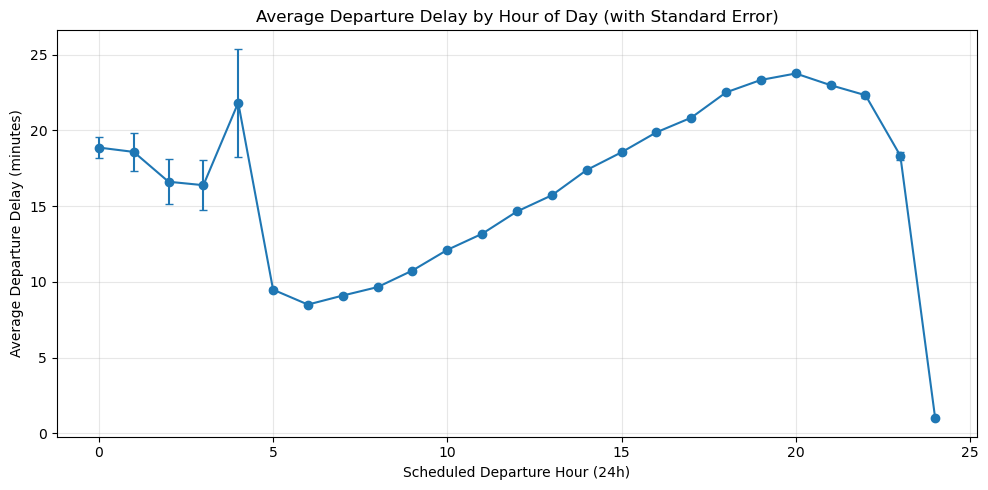

In [6]:
df_completed['DEP_HOUR'] = (df_completed['CRS_DEP_TIME'] // 100).astype(int)

# Group by hour and compute mean, std, and count
delay_by_hour = df_completed.groupby('DEP_HOUR')['DEP_DELAY_NEW'].agg(
    mean_delay='mean',
    std_delay='std',
    n='count'
).reset_index()

# Standard error and 95% CI
delay_by_hour['se_delay'] = delay_by_hour['std_delay'] / np.sqrt(delay_by_hour['n'])
delay_by_hour['ci95_delay'] = 1.96 * delay_by_hour['se_delay']  # optional

plt.figure(figsize=(10,5))

plt.errorbar(
    delay_by_hour['DEP_HOUR'],
    delay_by_hour['mean_delay'],
    yerr=delay_by_hour['se_delay'],   # or use 'ci95_delay' if you prefer 95% CI
    fmt='o-',
    capsize=3
)

plt.title("Average Departure Delay by Hour of Day (with Standard Error)")
plt.xlabel("Scheduled Departure Hour (24h)")
plt.ylabel("Average Departure Delay (minutes)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

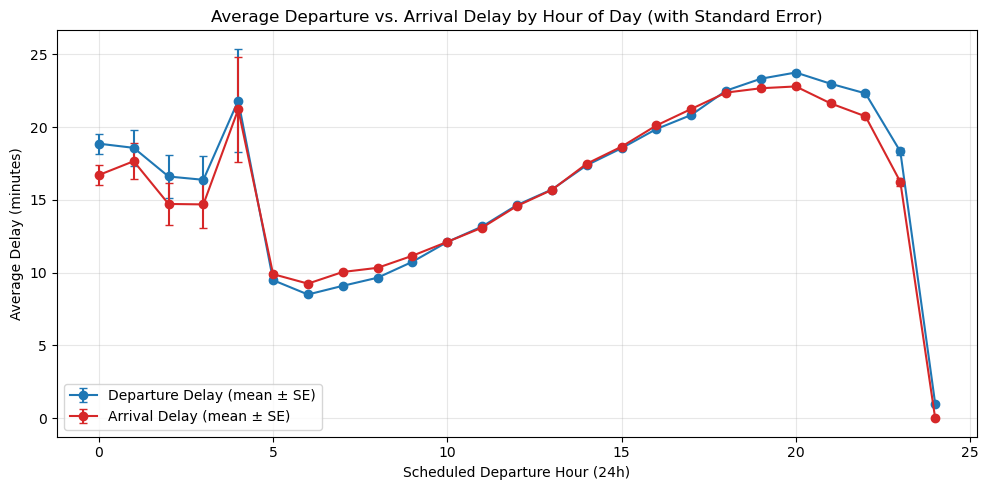

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Extract departure hour if not already extracted
df_completed['DEP_HOUR'] = (df_completed['CRS_DEP_TIME'] // 100).astype(int)

# We assume ARR_DELAY_NEW column exists
# Group by hour and compute mean, std, and count for BOTH delay types
delay_stats = df_completed.groupby("DEP_HOUR").agg(
    mean_dep=("DEP_DELAY_NEW", "mean"),
    std_dep=("DEP_DELAY_NEW", "std"),
    n_dep=("DEP_DELAY_NEW", "count"),
    
    mean_arr=("ARR_DELAY_NEW", "mean"),
    std_arr=("ARR_DELAY_NEW", "std"),
    n_arr=("ARR_DELAY_NEW", "count"),
).reset_index()

# Compute standard errors
delay_stats["se_dep"] = delay_stats["std_dep"] / np.sqrt(delay_stats["n_dep"])
delay_stats["se_arr"] = delay_stats["std_arr"] / np.sqrt(delay_stats["n_arr"])

# ---- PLOT ----
plt.figure(figsize=(10, 5))

# Departure delay line + SE error bars
plt.errorbar(
    delay_stats["DEP_HOUR"],
    delay_stats["mean_dep"],
    yerr=delay_stats["se_dep"],
    fmt='o-',
    capsize=3,
    label="Departure Delay (mean ± SE)",
    color="tab:blue"
)

# Arrival delay line + SE error bars
plt.errorbar(
    delay_stats["DEP_HOUR"],
    delay_stats["mean_arr"],
    yerr=delay_stats["se_arr"],
    fmt='o-',
    capsize=3,
    label="Arrival Delay (mean ± SE)",
    color="tab:red"
)

plt.title("Average Departure vs. Arrival Delay by Hour of Day (with Standard Error)")
plt.xlabel("Scheduled Departure Hour (24h)")
plt.ylabel("Average Delay (minutes)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


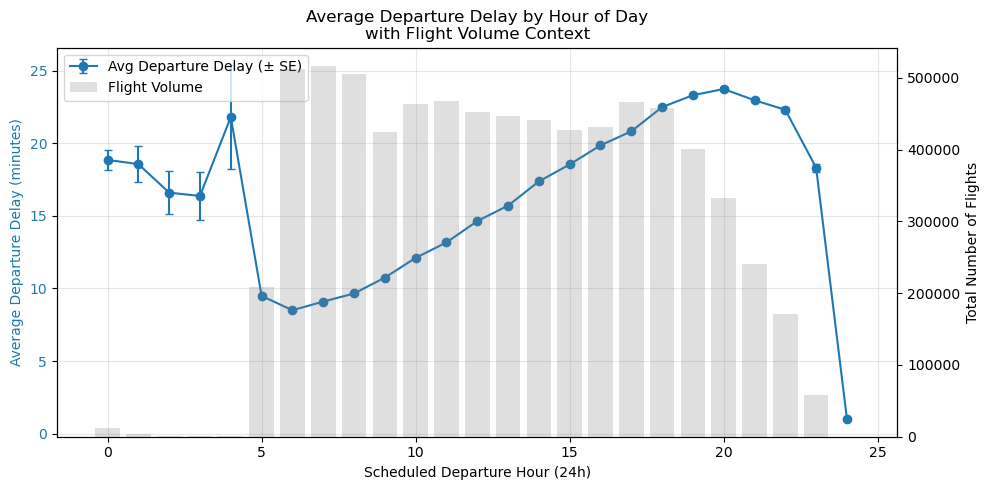

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure DEP_HOUR exists
df_completed['DEP_HOUR'] = (df_completed['CRS_DEP_TIME'] // 100).astype(int)

# Group by hour and compute stats for departure delay
by_hour = df_completed.groupby('DEP_HOUR').agg(
    FLIGHT_COUNT=('CRS_DEP_TIME', 'count'),
    mean_dep=('DEP_DELAY_NEW', 'mean'),
    std_dep=('DEP_DELAY_NEW', 'std')
).reset_index()

# Compute standard error
by_hour['se_dep'] = by_hour['std_dep'] / np.sqrt(by_hour['FLIGHT_COUNT'])

# --- PLOT ---
fig, ax1 = plt.subplots(figsize=(10, 5))

# 1) Average departure delay (line + error bars)
ax1.errorbar(
    by_hour['DEP_HOUR'],
    by_hour['mean_dep'],
    yerr=by_hour['se_dep'],
    fmt='o-',
    capsize=3,
    color='tab:blue',
    label='Avg Departure Delay (± SE)'
)

ax1.set_xlabel('Scheduled Departure Hour (24h)')
ax1.set_ylabel('Average Departure Delay (minutes)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(alpha=0.3)

# 2) Flight volume on secondary y-axis (bars)
ax2 = ax1.twinx()
ax2.bar(
    by_hour['DEP_HOUR'],
    by_hour['FLIGHT_COUNT'],
    alpha=0.25,
    color='gray',
    label='Flight Volume'
)
ax2.set_ylabel('Total Number of Flights')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Average Departure Delay by Hour of Day\nwith Flight Volume Context")
fig.tight_layout()
plt.show()


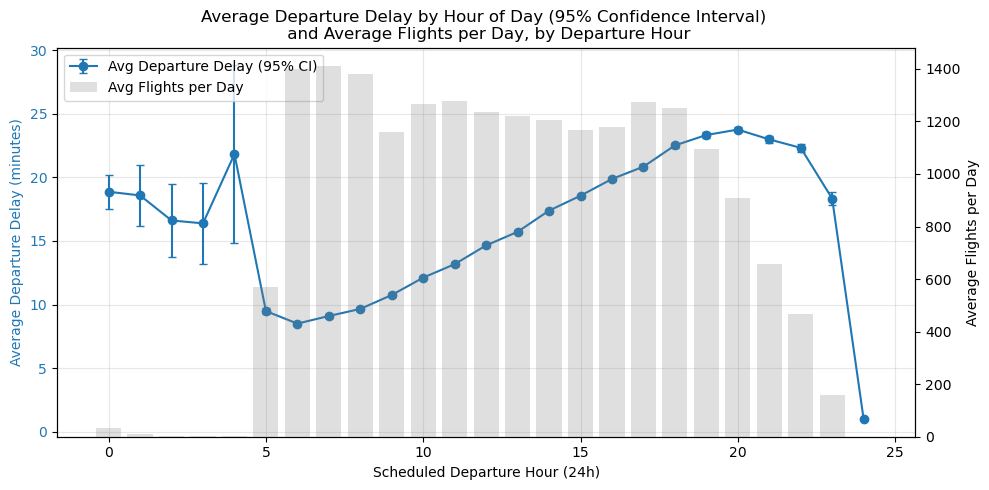

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure DEP_HOUR exists
df_completed['DEP_HOUR'] = (df_completed['CRS_DEP_TIME'] // 100).astype(int)

# ---- Identify number of distinct days ----
# Update this to your actual date column name if needed
DATE_COL = 'FL_DATE'
df_completed[DATE_COL] = pd.to_datetime(df_completed[DATE_COL])
num_days = df_completed[DATE_COL].nunique()

# ---- Group by hour and compute stats ----
by_hour = df_completed.groupby('DEP_HOUR').agg(
    FLIGHT_COUNT=('CRS_DEP_TIME', 'count'),
    mean_dep=('DEP_DELAY_NEW', 'mean'),
    std_dep=('DEP_DELAY_NEW', 'std')
).reset_index()

# ---- Compute standard error and 95% CI ----
by_hour['se_dep'] = by_hour['std_dep'] / np.sqrt(by_hour['FLIGHT_COUNT'])
by_hour['ci95_dep'] = 1.96 * by_hour['se_dep']    # <-- THIS is the change

# Convert to average flights per day in each hour
by_hour['AVG_FLIGHTS_PER_DAY'] = by_hour['FLIGHT_COUNT'] / num_days

# ---- PLOT ----
fig, ax1 = plt.subplots(figsize=(10, 5))

# 1) Mean departure delay with 95% CI
ax1.errorbar(
    by_hour['DEP_HOUR'],
    by_hour['mean_dep'],
    yerr=by_hour['ci95_dep'],   # <-- 95% CI instead of SE
    fmt='o-',
    capsize=3,
    color='tab:blue',
    label='Avg Departure Delay (95% CI)'
)

ax1.set_xlabel('Scheduled Departure Hour (24h)')
ax1.set_ylabel('Average Departure Delay (minutes)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(alpha=0.3)

# 2) Average flights per day (bars)
ax2 = ax1.twinx()
ax2.bar(
    by_hour['DEP_HOUR'],
    by_hour['AVG_FLIGHTS_PER_DAY'],
    alpha=0.25,
    color='gray',
    label='Avg Flights per Day'
)

ax2.set_ylabel('Average Flights per Day')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Average Departure Delay by Hour of Day (95% Confidence Interval) \n and Average Flights per Day, by Departure Hour")
fig.tight_layout()
plt.show()


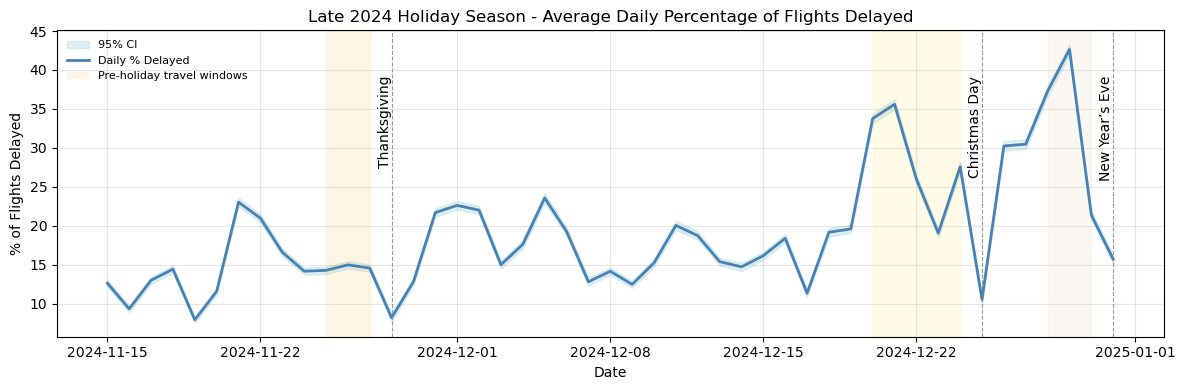

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

HOLY_ANNOT_FRAC = 0.92

# ---- Define delay indicator ----
df_completed['IS_DELAYED'] = df_completed['DEP_DELAY_NEW'] >= 15

# Ensure FL_DATE is datetime
df_completed['FL_DATE'] = pd.to_datetime(df_completed['FL_DATE'])

# ---- Daily aggregation ----
daily = (
    df_completed.groupby('FL_DATE')
    .agg(
        TOTAL_FLIGHTS=('IS_DELAYED', 'count'),
        DELAYED_FLIGHTS=('IS_DELAYED', 'sum')
    )
    .reset_index()
)

# % delayed
daily['PCT_DELAYED'] = daily['DELAYED_FLIGHTS'] / daily['TOTAL_FLIGHTS'] * 100

# ---- Compute 95% CI for proportion ----
p = daily['DELAYED_FLIGHTS'] / daily['TOTAL_FLIGHTS']  # raw proportion 0–1
n = daily['TOTAL_FLIGHTS']

# Standard error of proportion
se = np.sqrt(p * (1 - p) / n)

# 95% confidence interval
daily['CI_LOWER'] = (p - 1.96 * se) * 100
daily['CI_UPPER'] = (p + 1.96 * se) * 100

# filter for holiday season
mask = (daily['FL_DATE'] >= '2024-11-15') & (daily['FL_DATE'] <= '2025-01-02')
holiday = daily.loc[mask].copy()

# ---- Plot ----
fig, ax = plt.subplots(figsize=(12,4))

# Shaded 95% CI
ax.fill_between(
    holiday['FL_DATE'],
    holiday['CI_LOWER'],
    holiday['CI_UPPER'],
    color='lightblue',
    alpha=0.4,
    label='95% CI'
)

# Blue daily % delayed
ax.plot(
    holiday['FL_DATE'],
    holiday['PCT_DELAYED'],
    color='steelblue',
    linewidth=2,
    label='Daily % Delayed'
)

ax.set_ylabel('% of Flights Delayed', color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.set_xlabel('Date')
ax.set_title("Late 2024 Holiday Season - Average Daily Percentage of Flights Delayed")
ax.grid(alpha=0.3)

# ---- Holiday markers and windows ----
pre_windows = {
    'Thanksgiving': ('2024-11-28', 3),
    'Christmas Day': ('2024-12-25', 5),
    "New Year’s Eve": ('2024-12-31', 3),
}

ypos = holiday['PCT_DELAYED'].max() * HOLY_ANNOT_FRAC

for name, (date_str, days_before) in pre_windows.items():
    hdate = pd.to_datetime(date_str)
    ax.axvline(hdate, color='gray', linestyle='--', alpha=0.8, linewidth=0.8)
    ax.text(
        hdate, ypos, name,
        rotation=90, va='top', ha='right',
        fontsize=10, color='black'
    )

for name, (date_str, days_before) in pre_windows.items():
    hdate = pd.to_datetime(date_str)
    start = hdate - pd.Timedelta(days=days_before)
    end   = hdate - pd.Timedelta(days=1)
    color = {
        'Thanksgiving': 'orange',
        'Christmas Day': 'gold',
        "New Year’s Eve": 'tan'
    }.get(name, 'orange')
    ax.axvspan(start, end, color=color, alpha=0.10)

legend_patches = [Patch(facecolor='orange', alpha=0.10, label='Pre-holiday travel windows')]
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles + legend_patches, labels + ['Pre-holiday travel windows'],
          loc='upper left', frameon=False, fontsize=8)

fig.tight_layout()
plt.show()
